# **Preprocessing**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge as skRidge
from tensorflow.keras import optimizers

In [2]:
df = pd.read_csv("C:\Kuliah\MACHINE LEARNING\Dataset\Semarang\Laporan ISPU Stasiun Semarang Mijen 2023 - combined_data.csv", parse_dates=['Date'], index_col='Date')
df.head()

,PM10,PM2.5,SO2,CO,O3,NO2,HC,Critical Component
Date,,,,,,,,
2023-01-01 00:00:00,6.0,14.0,26.0,17.0,9.0,12.0,12.0,SO2
2023-01-01 01:00:00,6.0,14.0,26.0,17.0,8.0,12.0,12.0,SO2
2023-01-01 02:00:00,6.0,13.0,25.0,17.0,8.0,12.0,12.0,SO2
2023-01-01 03:00:00,6.0,13.0,25.0,17.0,8.0,12.0,12.0,SO2
2023-01-01 04:00:00,6.0,13.0,25.0,16.0,8.0,12.0,12.0,SO2


In [3]:
df.drop(columns=['Critical Component'], inplace=True)

print("Tanggal awal:", df.index.min(), ", tanggal akhir", df.index.max())

pollutants = ['PM10', 'PM2.5', 'SO2', 'CO', 'O3', 'NO2', 'HC']

print("Missing values setiap kolom sebelum interpolasi:")
print(df[pollutants].isna().sum())

df_interpolated = df[pollutants].interpolate(method='linear')

df_interpolated = df_interpolated.fillna(df_interpolated.mean())

df_interpolated = df_interpolated.round().astype(int)

print("Missing values setelah interpolasi slinear:")
print(df_interpolated.isna().sum())

df_interpolated.to_csv('Laporan ISPU Stasiun Semarang Mijen 2023 - interpolated_data.csv')


Tanggal awal: 2023-01-01 00:00:00 , tanggal akhir 2023-12-31 23:00:00
Missing values setiap kolom sebelum interpolasi:
PM10      780
PM2.5     780
SO2       780
CO        780
O3        784
NO2       780
HC       1851
dtype: int64
Missing values setelah interpolasi slinear:
PM10     0
PM2.5    0
SO2      0
CO       0
O3       0
NO2      0
HC       0
dtype: int64


In [4]:
df.head()

,PM10,PM2.5,SO2,CO,O3,NO2,HC
Date,,,,,,,
2023-01-01 00:00:00,6.0,14.0,26.0,17.0,9.0,12.0,12.0
2023-01-01 01:00:00,6.0,14.0,26.0,17.0,8.0,12.0,12.0
2023-01-01 02:00:00,6.0,13.0,25.0,17.0,8.0,12.0,12.0
2023-01-01 03:00:00,6.0,13.0,25.0,17.0,8.0,12.0,12.0
2023-01-01 04:00:00,6.0,13.0,25.0,16.0,8.0,12.0,12.0


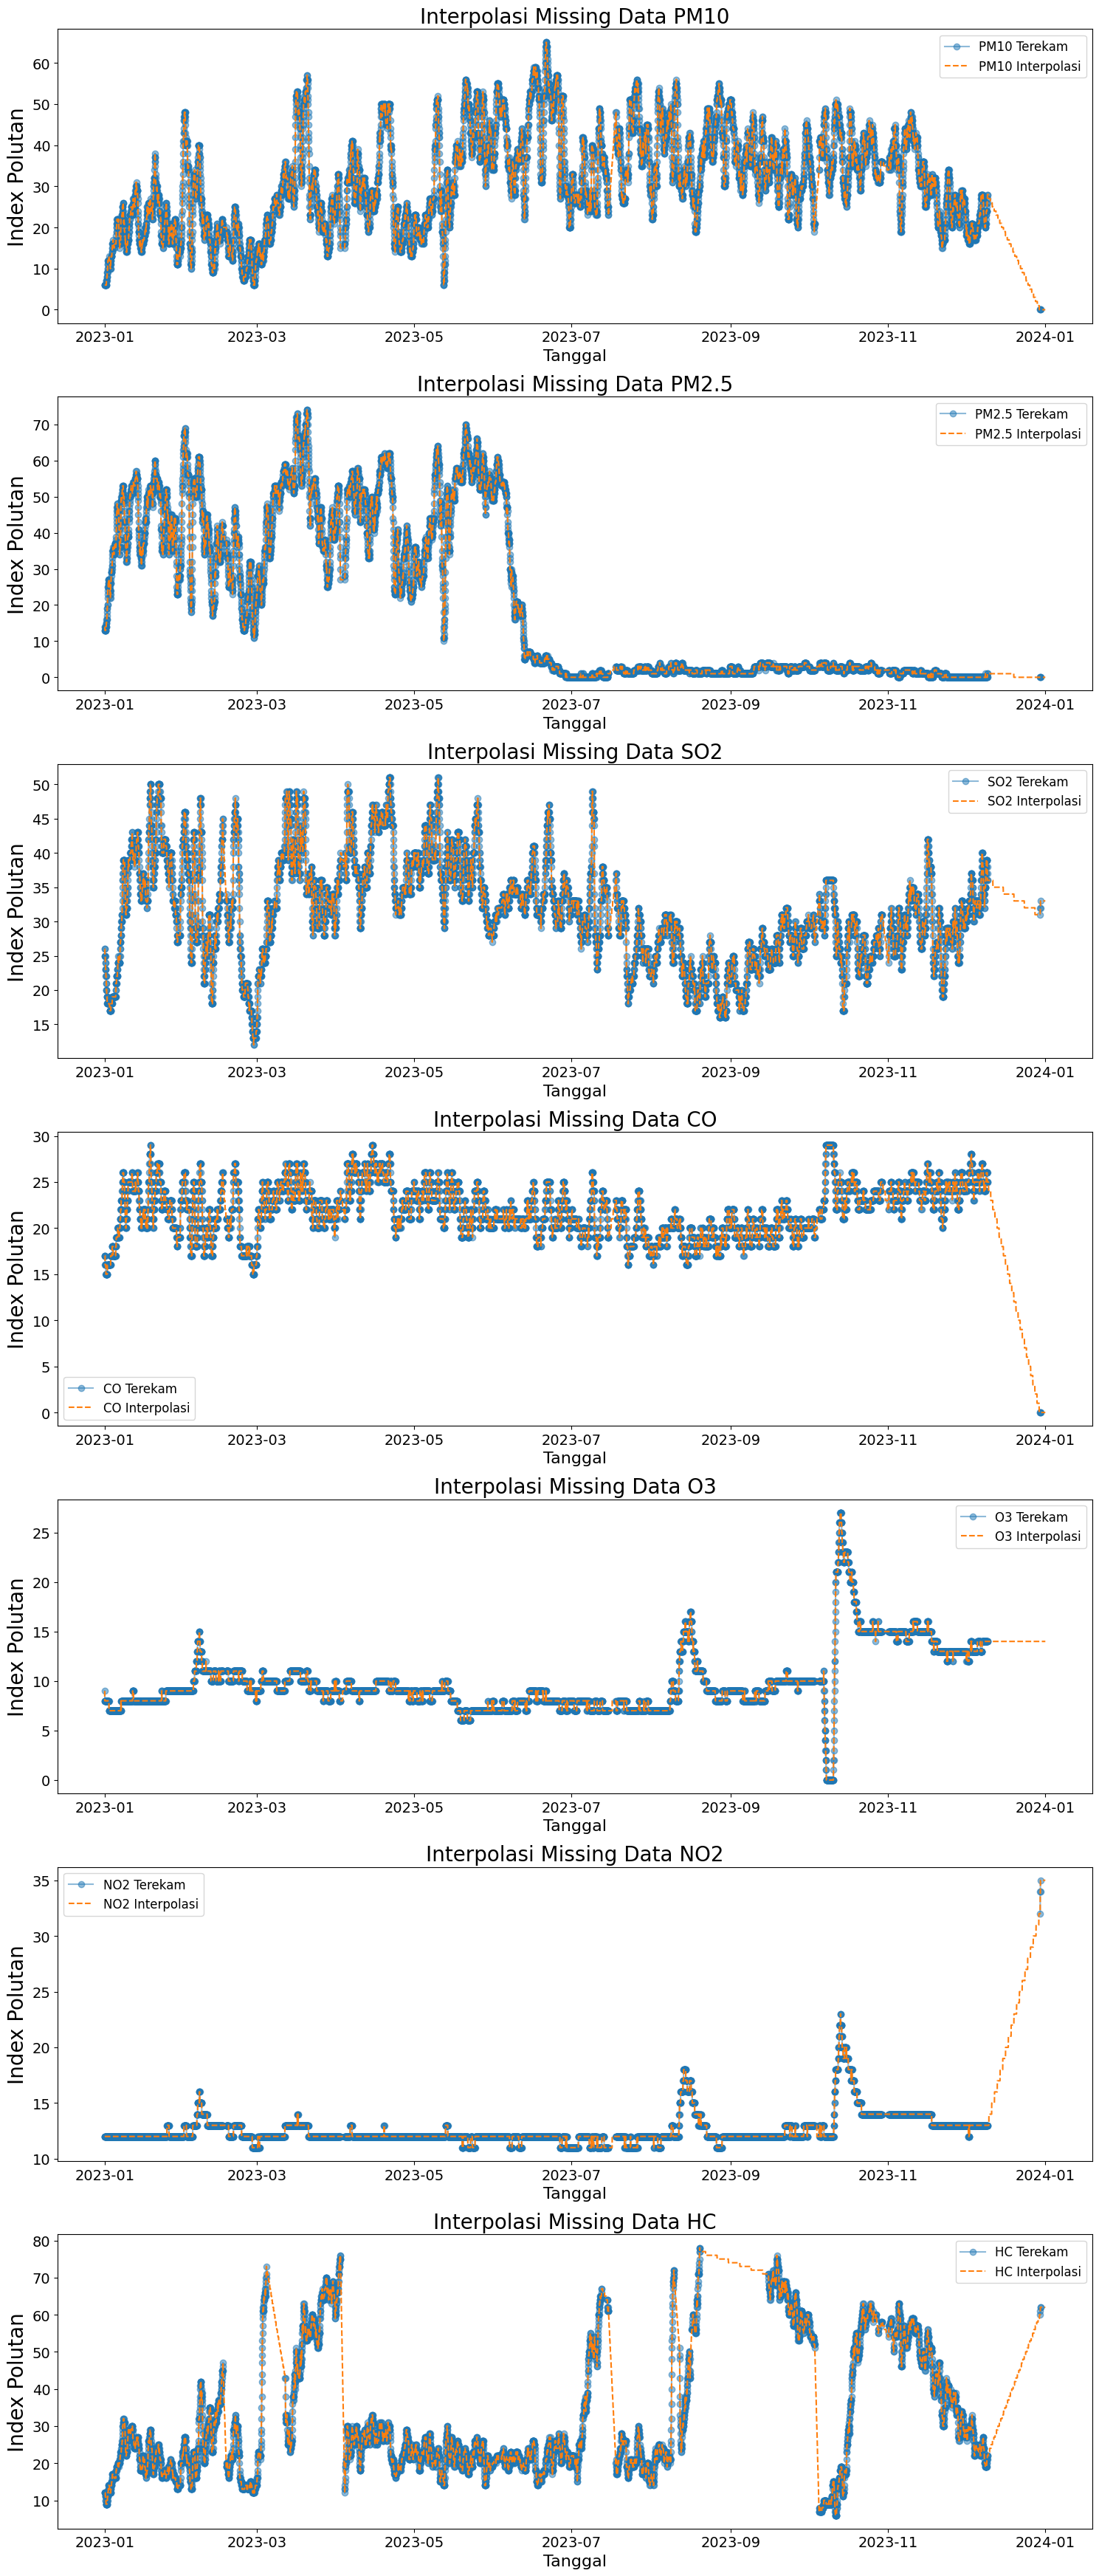

In [5]:
num_pollutants = len(pollutants)
fig, axs = plt.subplots(num_pollutants, 1, figsize=(15, 5 * num_pollutants), sharex=False)

for i, pollutant in enumerate(pollutants):
    ax = axs[i]
    ax.plot(df.index, df[pollutant], label=f'{pollutant} Terekam', marker='o', alpha=0.5)
    ax.plot(df_interpolated.index, df_interpolated[pollutant], label=f'{pollutant} Interpolasi', linestyle='--')
    ax.legend(fontsize=12)
    ax.set_ylabel('Index Polutan', fontsize=20)
    ax.set_title(f'Interpolasi Missing Data {pollutant}', fontsize=20)
    ax.set_xlabel('Tanggal', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14) 
    ax.tick_params(axis='both', which='minor', labelsize=14) 

plt.tight_layout()
plt.show()


# **Init**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge as skRidge
from tensorflow.keras import optimizers

In [2]:
path = 'C:\Kuliah\MACHINE LEARNING\.ipynb\Laporan ISPU Stasiun Semarang Mijen 2023 - interpolated_data.csv'
df = pd.read_csv(path, index_col='Date', date_format=lambda x:pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))
df.head()

,PM10,PM2.5,SO2,CO,O3,NO2,HC
Date,,,,,,,
2023-01-01 00:00:00,6,14,26,17,9,12,12
2023-01-01 01:00:00,6,14,26,17,8,12,12
2023-01-01 02:00:00,6,13,25,17,8,12,12
2023-01-01 03:00:00,6,13,25,17,8,12,12
2023-01-01 04:00:00,6,13,25,16,8,12,12


In [3]:
pollution = df.columns
pollution

Index(['PM10', 'PM2.5', 'SO2', 'CO', 'O3', 'NO2', 'HC'], dtype='object')

In [4]:
target_cols = pollution[0:7]
target_cols

Index(['PM10', 'PM2.5', 'SO2', 'CO', 'O3', 'NO2', 'HC'], dtype='object')

In [5]:
num_col = len(target_cols)
num_col

7

In [6]:
split_data = 0.8

In [7]:
target_cols = df.columns[0:num_col]

def preprocess_data(df, var):
  df = df.filter([var])
  return df

def create_dataset(dataset, time_step = 3):
  dataX, dataY = [], []
  for i in range(len(dataset) - time_step - 1):
    a = dataset[i:(i + time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return np.array(dataX), np.array(dataY)

# **SVR**

Prediksi Polutan PM10
MAE: 1.5261834708684257
MAPE: 321.5886599329897
MSE: 3.6040102691080107
RMSE: 1.8984231006569665
R2: 0.9742001309822595
CV: 46.900748618599664 

Prediksi Polutan PM2.5
MAE: 4.953725023658937
MAPE: 12219.188391692045
MSE: 24.585102124508403
RMSE: 4.958336628800873
R2: -27.50612335515337
CV: 106.16976868372063 

Prediksi Polutan SO2
MAE: 0.5199437107215034
MAPE: 155.98311321645102
MSE: 0.4954925087046706
RMSE: 0.7039122876500101
R2: 0.9725748630895089
CV: 13.910106992395715 

Prediksi Polutan CO
MAE: 0.24162954206343948
MAPE: 42.2851698611019
MSE: 0.15753754361436703
RMSE: 0.3969099943493071
R2: 0.9970685101939669
CV: 36.38931739502726 

Prediksi Polutan O3
MAE: 0.17195492291988967
MAPE: 29.01739324273138
MSE: 0.05765706804668839
RMSE: 0.24011886233007265
R2: 0.9193205143969267
CV: 5.965682533350013 

Prediksi Polutan NO2
MAE: 0.21787734950922058
MAPE: 65.36320485276616
MSE: 0.09589025773413434
RMSE: 0.3096615212359042
R2: 0.9971657193941268
CV: 34.89373911946754 



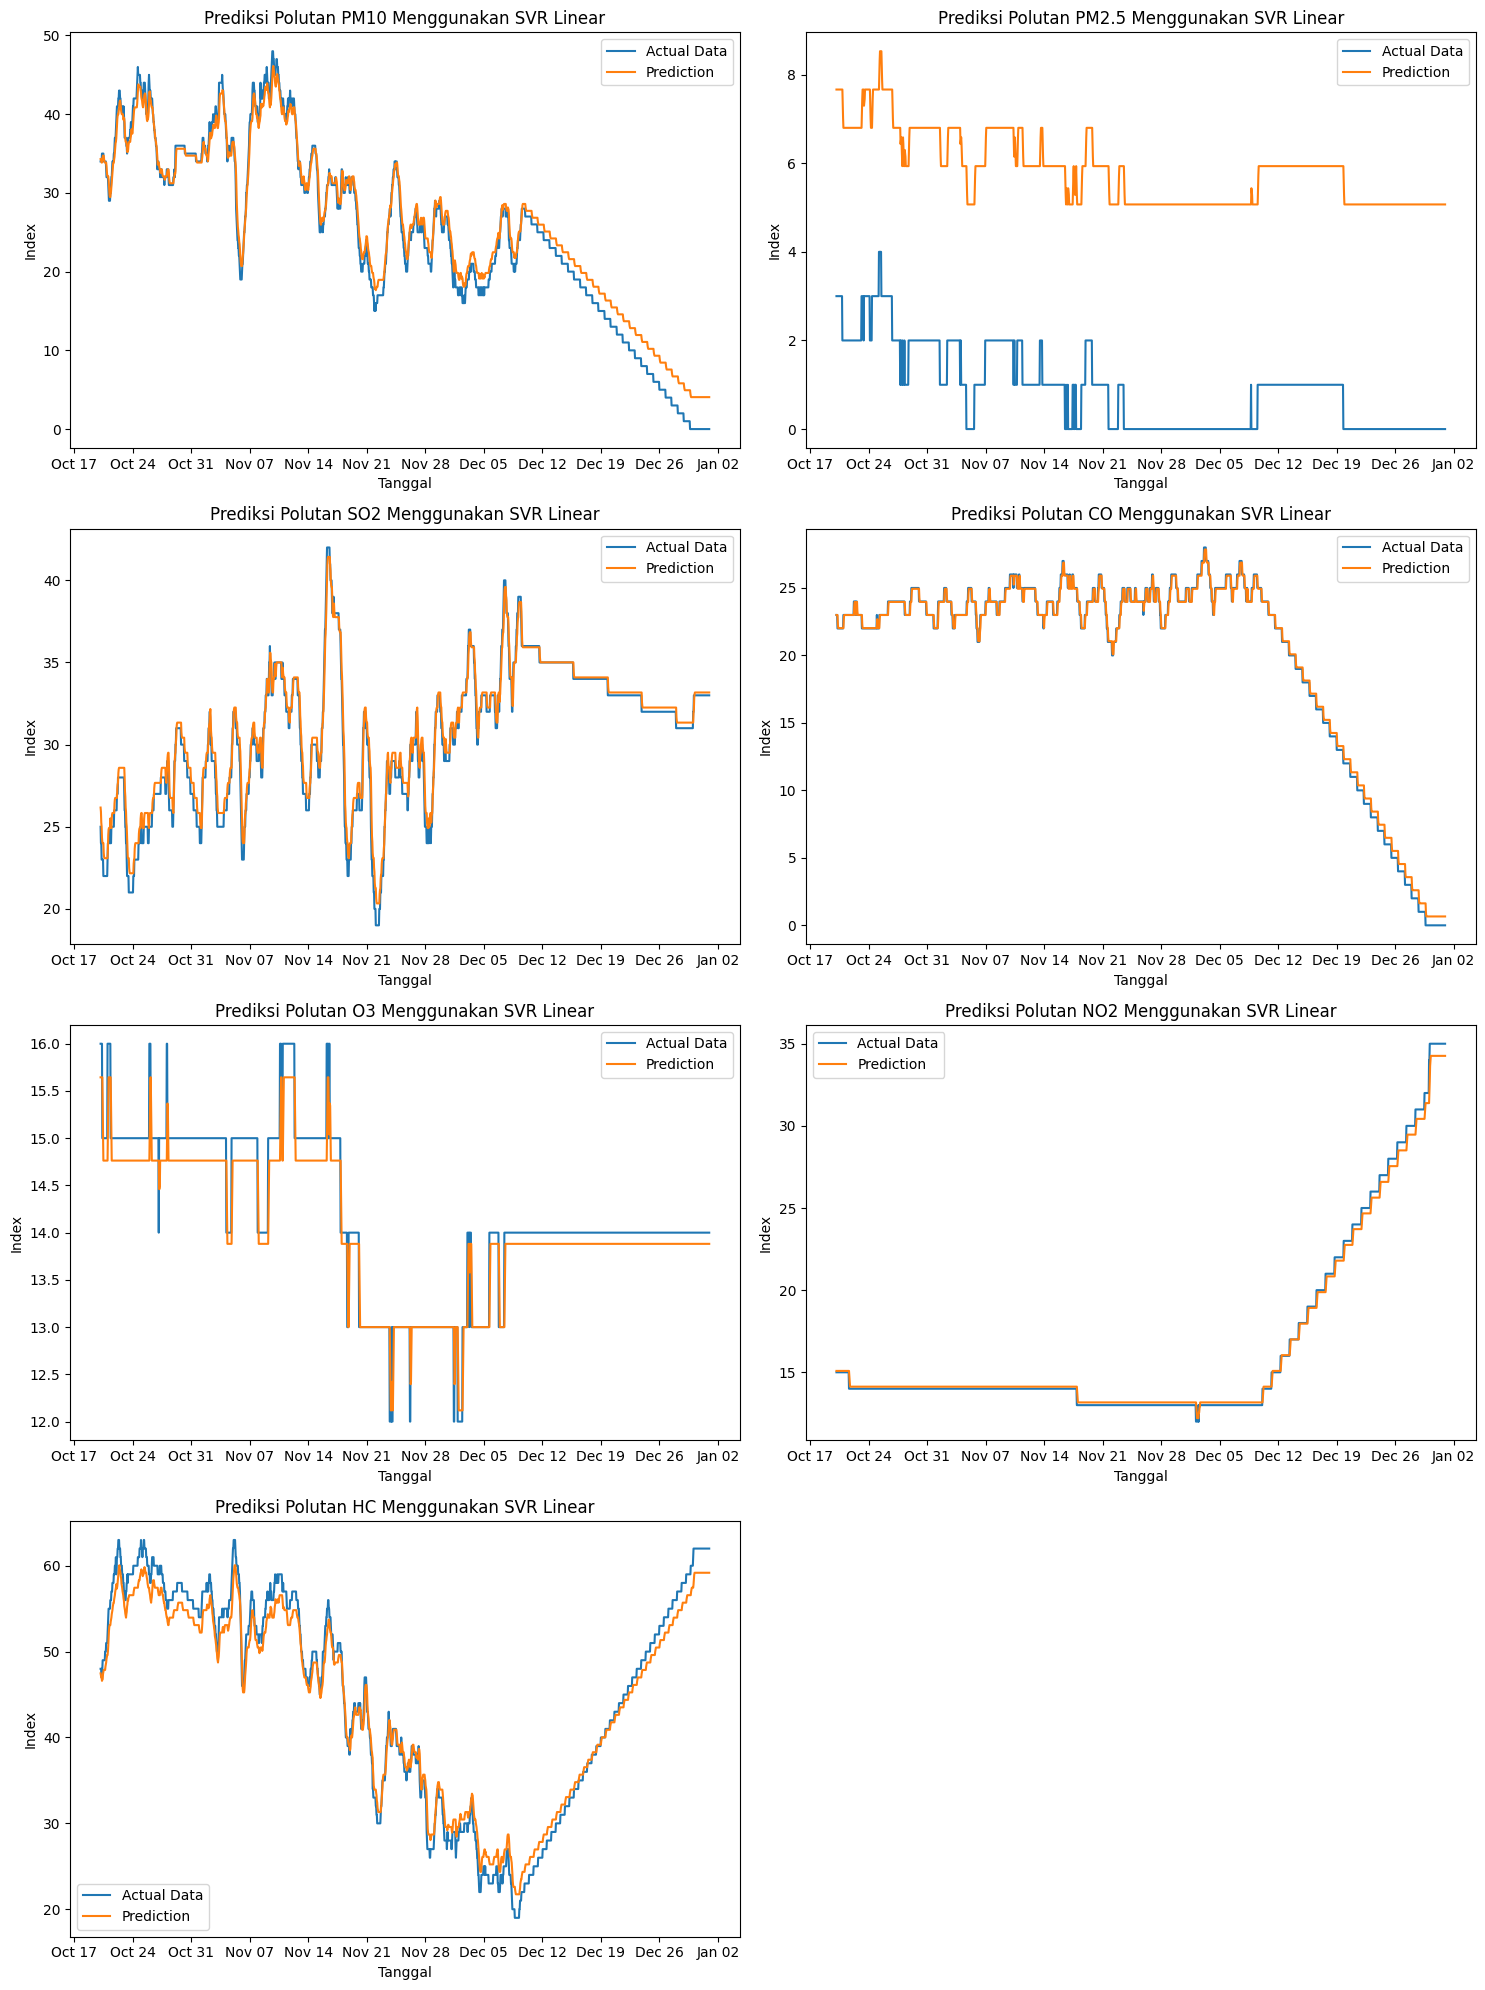

In [8]:
time_step = 3
all_actuals = []
all_predictions = []
history_dict = {}
x_ticks = None

n_cols = len(target_cols)
n_rows = (n_cols + 1) // 2

fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))

for i, col in enumerate(target_cols):
    df_col = preprocess_data(df, col)

    split = int(len(df_col) * split_data)
    train = df_col[:split]
    test = df_col[split:]

    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)

    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)

    svr = SVR(kernel='linear')
    svr.fit(X_train, y_train)

    y_pred_SVR = svr.predict(X_test)

    y_test_SVR = scaler.inverse_transform([y_test])
    y_pred_SVR = scaler.inverse_transform([y_pred_SVR])

    all_actuals.append(y_test_SVR.flatten())
    all_predictions.append(y_pred_SVR.flatten())

    if x_ticks is None:
        x_ticks = df_col.index[split + 1 + time_step:]

    x_ticks = pd.to_datetime(x_ticks)

    ax = axes[i // 2, i % 2]
    ax.plot(x_ticks, y_test_SVR.flatten(), label='Actual Data')
    ax.plot(x_ticks, y_pred_SVR.flatten(), label='Prediction')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax.legend()
    ax.set_title('Prediksi Polutan ' + col + ' Menggunakan SVR Linear')
    ax.set_xlabel('Tanggal')
    ax.set_ylabel('Index')

    print('Prediksi Polutan ' + col)

    mae_SVR = mean_absolute_error(y_test_SVR, y_pred_SVR)
    print('MAE:', mae_SVR)

    mape_SVR = np.mean(np.abs((y_test_SVR[0] - y_pred_SVR[0]) / y_test[0])) * 100
    print('MAPE:', mape_SVR)

    mse_SVR = mean_squared_error(y_test_SVR, y_pred_SVR)
    print('MSE:', mse_SVR)

    rmse_SVR = np.sqrt(mse_SVR)
    print('RMSE:', rmse_SVR)

    r2_SVR = r2_score(all_actuals[i], all_predictions[i])
    print('R2:', r2_SVR)

    cv_SVR = np.std(y_test_SVR[0]) / np.mean(y_test_SVR[0]) * 100
    print('CV:', cv_SVR, "\n")

if n_cols % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()

plt.savefig('SVR_8020.png')

plt.show()

# **LSTM**

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 3, 32)             4352      
                                                                 
 lstm_43 (LSTM)              (None, 3, 16)             3136      
                                                                 
 lstm_44 (LSTM)              (None, 8)                 800       
                                                                 
 dense_28 (Dense)            (None, 1)                 9         
                                                                 
Total params: 8,297
Trainable params: 8,297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
219/219 [==============================] - 7s 14ms/step - loss: 0.0286 - val_loss: 0.0028
Epoch 2/25
219/219 [==============================] - 3s 11ms/step - loss: 0.0010 

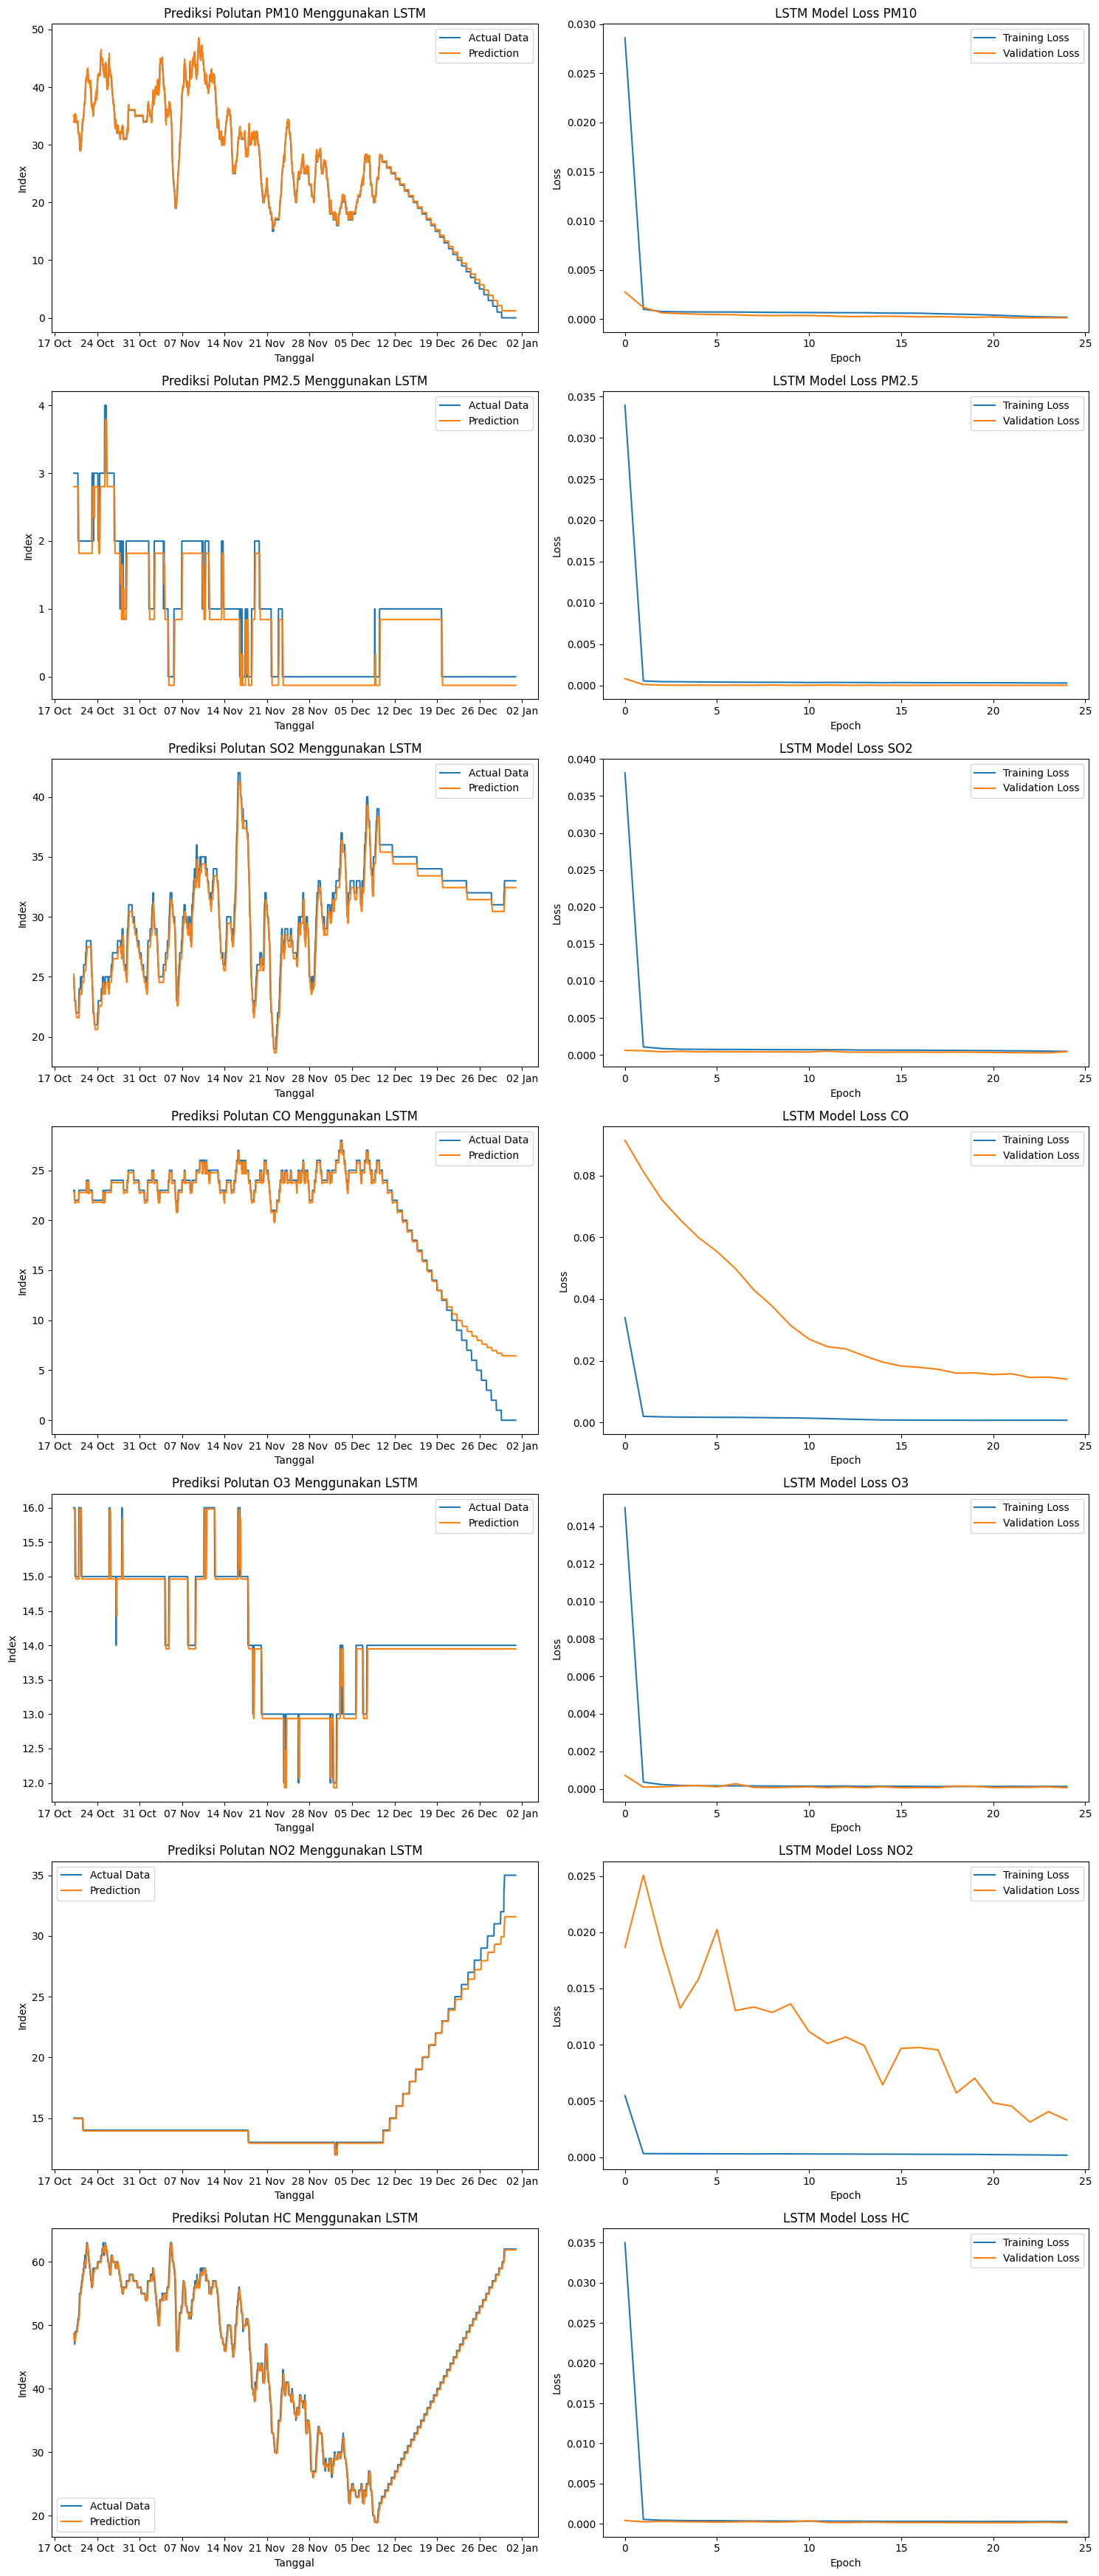

Prediksi Polutan PM10 Menggunakan LSTM
MAE: 0.5181270003727974
MAPE: inf
MSE: 0.45374249223241186
RMSE: 0.6736041064545345
R2: 0.9967518136760812
CV: 46.900748618599664 

Prediksi Polutan PM2.5 Menggunakan LSTM
MAE: 0.1902949577389238
MAPE: inf
MSE: 0.06374279790298848
RMSE: 0.2524733607788918
R2: 0.9260910102865177
CV: 106.16976868372063 

Prediksi Polutan SO2 Menggunakan LSTM
MAE: 0.6935104647271967
MAPE: 2.3036664323672533
MSE: 0.6770036168442966
RMSE: 0.822802295113654
R2: 0.9625283600565615
CV: 13.910106992395715 

Prediksi Polutan CO Menggunakan LSTM
MAE: 0.7886477343277746
MAPE: inf
MSE: 2.7564212347193124
RMSE: 1.6602473414281718
R2: 0.9487079678575374
CV: 36.38931739502726 

Prediksi Polutan O3 Menggunakan LSTM
MAE: 0.09479497008247342
MAPE: 0.6764824086710056
MSE: 0.043817927886838096
RMSE: 0.20932732236102886
R2: 0.9386856112898425
CV: 5.965682533350013 

Prediksi Polutan NO2 Menggunakan LSTM
MAE: 0.2665668472272572
MAPE: 1.0877449508829797
MSE: 0.4770046502967423
RMSE: 0.69

C:\Users\Sev\AppData\Local\Temp\ipykernel_16908\2662474744.py:86: RuntimeWarning: divide by zero encountered in divide
  mape_LSTM = np.mean(np.abs((y_test_LSTM - y_pred_LSTM) / y_test_LSTM)) * 100
C:\Users\Sev\AppData\Local\Temp\ipykernel_16908\2662474744.py:86: RuntimeWarning: divide by zero encountered in divide
  mape_LSTM = np.mean(np.abs((y_test_LSTM - y_pred_LSTM) / y_test_LSTM)) * 100
C:\Users\Sev\AppData\Local\Temp\ipykernel_16908\2662474744.py:86: RuntimeWarning: divide by zero encountered in divide
  mape_LSTM = np.mean(np.abs((y_test_LSTM - y_pred_LSTM) / y_test_LSTM)) * 100


In [32]:

time_step = 3
all_actuals = []
all_predictions = []
history_dict = {}
x_ticks = None

fig, axs = plt.subplots(len(target_cols), 2, figsize=(15, 5 * len(target_cols)))

for idx, col in enumerate(target_cols):
    df_col = preprocess_data(df, col)

    split = int(len(df_col) * split_data)
    train = df_col[:split]
    test = df_col[split:]

    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)

    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)

    X_train = np.reshape(X_train, (X_train.shape[0], time_step, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], time_step, 1))

    model_LSTM = Sequential()
    model_LSTM.add(LSTM(32, activation='tanh', return_sequences=True, input_shape=(time_step, 1)))
    model_LSTM.add(LSTM(16, return_sequences=True))
    model_LSTM.add(LSTM(8))
    model_LSTM.add(Dense(1))

    adam_optimizer = optimizers.Adam(learning_rate=0.001)
    model_LSTM.compile(loss='mean_squared_error', optimizer=adam_optimizer)
    model_LSTM.summary()

    history = model_LSTM.fit(X_train, y_train,
                             validation_data=(X_test, y_test),
                             epochs=25,
                             batch_size=32,
                             verbose=1)

    history_dict[col] = history

    y_pred_LSTM = model_LSTM.predict(X_test)

    y_test_LSTM = scaler.inverse_transform([y_test])
    y_pred_LSTM = scaler.inverse_transform(y_pred_LSTM)

    all_actuals.append(y_test_LSTM.flatten())
    all_predictions.append(y_pred_LSTM.flatten())

    if x_ticks is None:
        x_ticks = df_col.index[split + 1 + time_step:]

    x_ticks = pd.to_datetime(x_ticks)

    ax1 = axs[idx, 0]
    ax1.plot(x_ticks, y_test_LSTM.flatten(), label='Actual Data')
    ax1.plot(x_ticks, y_pred_LSTM.flatten(), label='Prediction')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.legend()
    ax1.set_title('Prediksi Polutan ' + col + ' Menggunakan LSTM')
    ax1.set_xlabel('Tanggal')
    ax1.set_ylabel('Index')

    ax2 = axs[idx, 1]
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('LSTM Model Loss ' + col)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

plt.tight_layout()
plt.show()

for idx, col in enumerate(target_cols):
    print(f'Prediksi Polutan {col} Menggunakan LSTM')
    y_test_LSTM = all_actuals[idx]
    y_pred_LSTM = all_predictions[idx]

    mae_LSTM = mean_absolute_error(y_test_LSTM, y_pred_LSTM)
    print('MAE:', mae_LSTM)

    mape_LSTM = np.mean(np.abs((y_test_LSTM - y_pred_LSTM) / y_test_LSTM)) * 100
    print('MAPE:', mape_LSTM)

    mse_LSTM = mean_squared_error(y_test_LSTM, y_pred_LSTM)
    print('MSE:', mse_LSTM)

    rmse_LSTM = np.sqrt(mse_LSTM)
    print('RMSE:', rmse_LSTM)

    r2_LSTM = r2_score(y_test_LSTM, y_pred_LSTM)
    print('R2:', r2_LSTM)

    cv_LSTM = np.std(y_test_LSTM) / np.mean(y_test_LSTM) * 100
    print('CV:', cv_LSTM, '\n')

# **GRU**

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_42 (GRU)                (None, 3, 32)             3360      
                                                                 
 gru_43 (GRU)                (None, 3, 16)             2400      
                                                                 
 gru_44 (GRU)                (None, 8)                 624       
                                                                 
 dense_35 (Dense)            (None, 1)                 9         
                                                                 
Total params: 6,393
Trainable params: 6,393
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
219/219 [==============================] - 5s 13ms/step - loss: 0.0126 - val_loss: 4.0880e-04
Epoch 2/25
219/219 [==============================] - 2s 11ms/step - loss: 5.7

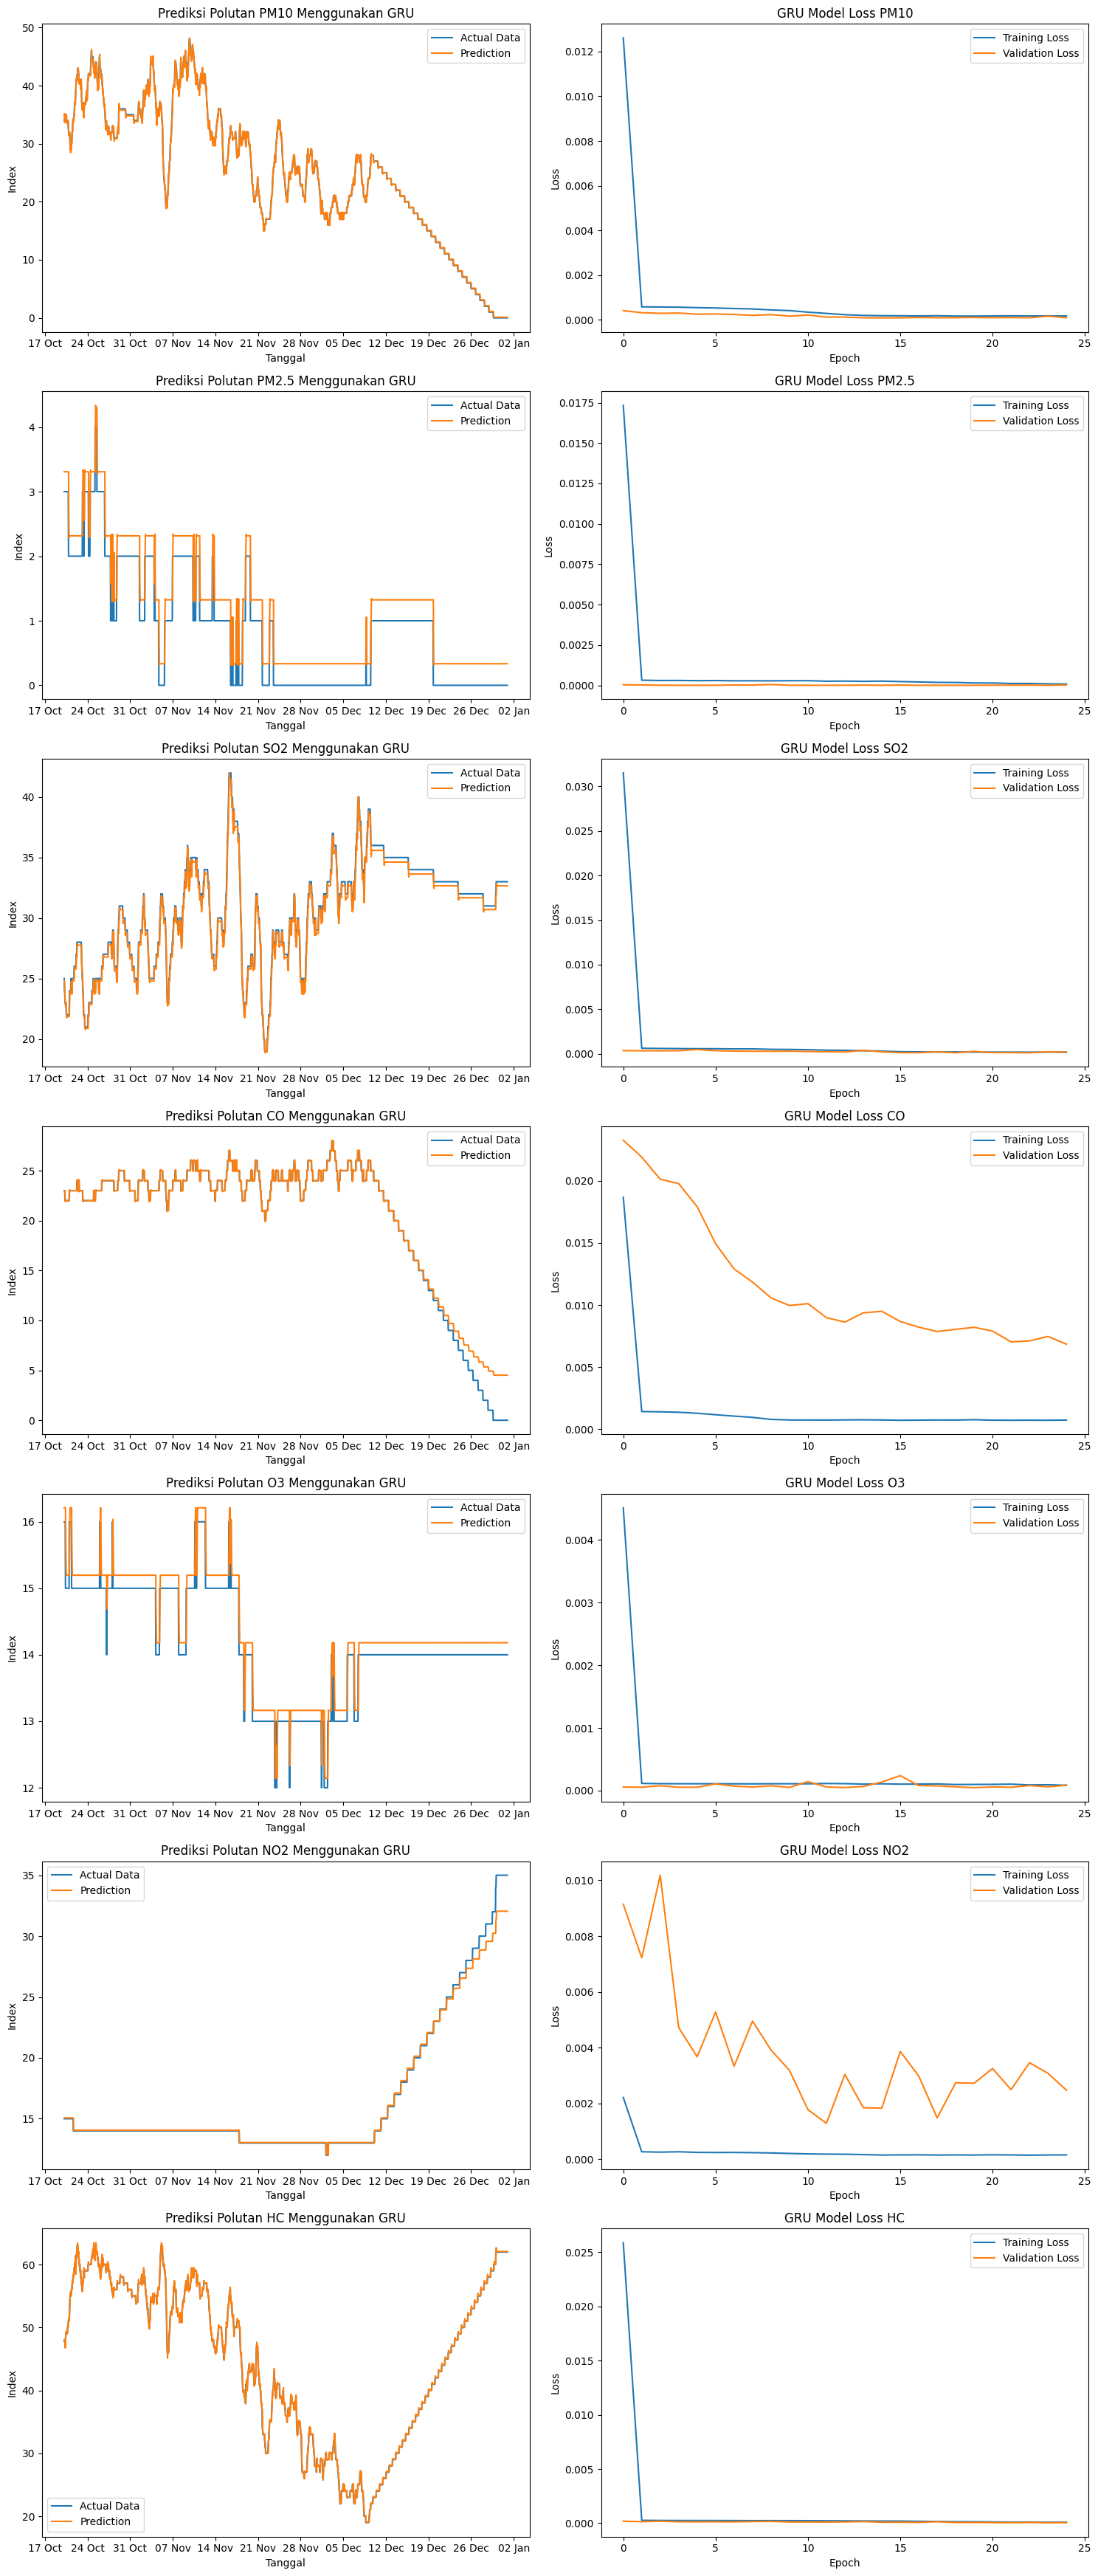

Prediksi Polutan PM10 Menggunakan GRU
MAE: 0.3782649847425227
MAPE: inf
MSE: 0.32368489538868134
RMSE: 0.5689331203126439
R2: 0.9976828512461159
CV: 46.900748618599664 

Prediksi Polutan PM2.5 Menggunakan GRU
MAE: 0.3462089286175145
MAPE: inf
MSE: 0.13728394797814109
RMSE: 0.3705184853393162
R2: 0.8408209518134918
CV: 106.16976868372063 

Prediksi Polutan SO2 Menggunakan GRU
MAE: 0.4144941827525266
MAPE: 1.366691516408905
MSE: 0.2617441560752208
RMSE: 0.5116093784081961
R2: 0.9855126582344307
CV: 13.910106992395715 

Prediksi Polutan CO Menggunakan GRU
MAE: 0.48567274724318726
MAPE: inf
MSE: 1.3421663567638686
RMSE: 1.158519035995468
R2: 0.9750247026671617
CV: 36.38931739502726 

Prediksi Polutan O3 Menggunakan GRU
MAE: 0.20895306523931867
MAPE: 1.4784579787330956
MSE: 0.06263478580323206
RMSE: 0.25026942642526684
R2: 0.9123551982322194
CV: 5.965682533350013 

Prediksi Polutan NO2 Menggunakan GRU
MAE: 0.2270108453196306
MAPE: 0.9114721082364207
MSE: 0.35636411868934526
RMSE: 0.59696240

C:\Users\Sev\AppData\Local\Temp\ipykernel_16908\3865364666.py:86: RuntimeWarning: divide by zero encountered in divide
  mape_GRU = np.mean(np.abs((y_test_GRU - y_pred_GRU) / y_test_GRU)) * 100
C:\Users\Sev\AppData\Local\Temp\ipykernel_16908\3865364666.py:86: RuntimeWarning: divide by zero encountered in divide
  mape_GRU = np.mean(np.abs((y_test_GRU - y_pred_GRU) / y_test_GRU)) * 100
C:\Users\Sev\AppData\Local\Temp\ipykernel_16908\3865364666.py:86: RuntimeWarning: divide by zero encountered in divide
  mape_GRU = np.mean(np.abs((y_test_GRU - y_pred_GRU) / y_test_GRU)) * 100


In [33]:
time_step = 3
all_actuals = []
all_predictions = []
history_dict = {}
x_ticks = None

fig, axs = plt.subplots(len(target_cols), 2, figsize=(15, 5 * len(target_cols)))

for idx, col in enumerate(target_cols):
    df_col = preprocess_data(df, col)

    split = int(len(df_col) * split_data)
    train = df_col[:split]
    test = df_col[split:]

    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)

    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)

    X_train = np.reshape(X_train, (X_train.shape[0], time_step, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], time_step, 1))

    model_GRU = Sequential()
    model_GRU.add(GRU(32, activation='tanh', return_sequences=True, input_shape=(time_step, 1)))
    model_GRU.add(GRU(16, return_sequences=True))
    model_GRU.add(GRU(8))
    model_GRU.add(Dense(1))

    adam_optimizer = optimizers.Adam(learning_rate=0.001)
    model_GRU.compile(loss='mean_squared_error', optimizer=adam_optimizer)
    model_GRU.summary()

    history = model_GRU.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=25,
                            batch_size=32,
                            verbose=1)

    history_dict[col] = history

    y_pred_GRU = model_GRU.predict(X_test)

    y_test_GRU = scaler.inverse_transform([y_test])
    y_pred_GRU = scaler.inverse_transform(y_pred_GRU)

    all_actuals.append(y_test_GRU.flatten())
    all_predictions.append(y_pred_GRU.flatten())

    if x_ticks is None:
        x_ticks = df_col.index[split + 1 + time_step:]

    x_ticks = pd.to_datetime(x_ticks)

    ax1 = axs[idx, 0]
    ax1.plot(x_ticks, y_test_GRU.flatten(), label='Actual Data')
    ax1.plot(x_ticks, y_pred_GRU.flatten(), label='Prediction')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.legend()
    ax1.set_title('Prediksi Polutan ' + col + ' Menggunakan GRU')
    ax1.set_xlabel('Tanggal')
    ax1.set_ylabel('Index')

    ax2 = axs[idx, 1]
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('GRU Model Loss ' + col)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

plt.tight_layout()
plt.show()

for idx, col in enumerate(target_cols):
    print(f'Prediksi Polutan {col} Menggunakan GRU')
    y_test_GRU = all_actuals[idx]
    y_pred_GRU = all_predictions[idx]

    mae_GRU = mean_absolute_error(y_test_GRU, y_pred_GRU)
    print('MAE:', mae_GRU)

    mape_GRU = np.mean(np.abs((y_test_GRU - y_pred_GRU) / y_test_GRU)) * 100
    print('MAPE:', mape_GRU)

    mse_GRU = mean_squared_error(y_test_GRU, y_pred_GRU)
    print('MSE:', mse_GRU)

    rmse_GRU = np.sqrt(mse_GRU)
    print('RMSE:', rmse_GRU)

    r2_GRU = r2_score(y_test_GRU, y_pred_GRU)
    print('R2:', r2_GRU)

    cv_GRU = np.std(y_test_GRU) / np.mean(y_test_GRU) * 100
    print('CV:', cv_GRU, '\n')